<a href="https://colab.research.google.com/github/zheyun-shou/DD2412/blob/main/VAE_Practical_Bernoulli.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Variational Auto-Encoders (VAEs) and the Evidence Lower-BOund (ELBO)**

### This practical



*   provides skeleton code for a VAE – you are tasked with filling in the missing bits and pieces
*   has a couple of experiments to visualize interesting/useful aspects of the VAE
*   is implemented using the python library [JAX](https://jax.readthedocs.io/en/latest/index.html)
*   will give a conceptual, rather than technical, introduction to the ELBO and variants thereof





### Before getting started, let us recap the VAE.

#### Background

VAE was simultaneously proposed by [Diederik P. Kingma and Max Welling](https://arxiv.org/abs/1312.6114) [1] and [Danilo Jimenez Rezende, Shakir Mohamed and Daan Wierstra](https://arxiv.org/abs/1401.4082) [2] independently. The former was published slightly prior to the latter, and has recieved considerably more citations. If you have not yet read/looked at either, I recommend checking out [1], as it will help you in this practical (and, of course, since it is a great piece of work).

Essentially, a VAE can be seen as a mapping from an input space to a latent (hidden or unobserved) space, then from the latent space to an output space. It consists of two parts, called encoder and decoder. With the help of encoder, we can map a given input sample $x_{ori} \sim p(x)$ to a distribution over the latent space. The distribution is denoted by $q_{\phi}(z|x_{ori})$ and $\phi$ denotes the parameters of the encoder (optimized via training), called ([variational](https://www.cs.jhu.edu/~jason/tutorials/variational.html)) parameters.

In mathematics, finding the best function (the distribution over the latent space in our case, i.e. $q_{\phi}(z|x_{ori})$) is done under the name of calculus of variations and this name also comes from that mathematical background. Variational approximation, (finding the best or closest function to a given function, in our case the true distribution over the latent sapce $p(z|x_{ori})$) is usually done because of the complexity of the original function (it means, it is hard to work with $p(z|x_{ori})$ because it has interactable terms).

So the idea of variational approximation is that to fix a family of distributions, say $Q$ (think of it as the set of all possible normal distributions $Q=\{\mathcal{N}(\mu,\sigma)| \mu \in \mathbb{R}, \sigma \in \mathbb{R}^+\}$), and then approximate a complex function, needless to say $p(z|x_{ori})$, with a simpler function $q_\phi(z|x_{ori}) \in Q$. To this end, we need to find the closest $q_\phi(z|x_{ori})$ to $p(z|x_{ori})$, and the parameters of $q_\phi(z|x_{ori})$ (in our example, a good $\mu$ and $\sigma$) are called **variational parameters**. The subscript $\phi$, also called variational paramters or encoder paramters, denotes that the distribution we get, depends on some other variables that has to be optimized (i.e. the variables that we use to map a given input $x$ to a distribution over the latent space, for example $\phi=\{W_1,W_2,b_1,b_2\}$ if we are using a two layer MLP).

Note that $q_\phi(z|x)$ is a function of two variables both $x$ and $z$ and when you plug in some specific $x$, you still have a function of $z$.  Therefore, $q_\phi(z|x)$ gives us the paramters of a distribution (in our example it gives us some specific $\mu$ and $\sigma$ after plugging it $x$). Then, after getting the paramters of a distribution over the latent space $q_\phi(z|x_{ori})$, it is time to reconstruct the input sample $x_{ori}$ from its latent representation $q_\phi(z|x_{ori})$, but the problem is that we can not use a function as input into the decoder! So what we can do is to draw (several) samples from the latent distribution $q_\phi(z|x_{ori})$ and recover a distribution over the  input space. Another the problem is that it is that, sampling is not differentiable, making our model indifferentiable. To see why, try to diffrentiate a sample drawn from a Normal distribution, i.e. while $x \sim \mathcal{N}(\mu,\sigma)$ try to compute the following:
$$
\frac{dx}{d\mu}
$$

To solve the problem regarding the sampling and indifferentiability, [1] have proposed a trick called **reparameterization trick**, of which you'll hear more in the rest of this practical. But for now, it suffices to assume that we know we can use a sample like $z_{ori} \sim q_\phi(z|x_{ori})$, to map it back to the input sapce again, using a decoder, or so called **the generative** model. In our example, it is as simple as $z_{ori} \sim \mathcal{N}(\mu_{ori},\sigma_{ori})$ where the $\mu_{ori}$ and $\sigma_{ori}$ is obtained simply by plugging in $x_{ori}$ into the encoder, i.e. $q_\phi(z|x_{ori})$.

As the decoder is acting on samples of a distribution, and becomes stochastic by virtue of sampling, it defines a distribution over the input space. Therefore, the **distribution recovered** from $z_{ori}$ by the decoder, is denoted by $p_\theta(x|z_{ori})$.

The $\theta$ subscript is the parameters of the generative model, also called generative paramters are optimized jointly with $\phi$. Finally, we can *decode* $z_{ori}$ by sampling from $p_{\theta}(x|z_{ori})$. The decoding of $z_{ori}$, i.e. $x_{rec}\sim p_{\theta}(x|z_{ori})$, is commonly referred to as the *reconstruction*.

Note that in the original paper you do not see any distinction between $x_{ori}$, $x_{rec}$ and $x$ as they are in the same space, but it is added here to make it easy to explain the idea! Following [1], we avoid the use of subscripts in the rest of the practical.

### Why?
There are plenty of interesting tasks that can be tackled using VAEs. Some important examples include dimensionality reduction (encoding $x$ as $z$, such that dim($z$) < dim($x$)), noise filtering (a.k.a. reconstructing the input), generating synthetic data (sampling from $p_{\theta}(x|z)$) and density estimation. Let us zoom in on the latter.

Say we are interested in learning the posterior distribution $p(z|x)$ for whatever reason. In most interesting scenarios, however, we cannot learn it since it is intractable. The intractability of

$$
  p(z|x) = \frac{p(z,x)}{p(x)}
$$

stems from not being able to compute $p(x) = \int p(z, x) dz$ as it involves marginalizing over all $z$. Instead of learning $p(z|x)$ directly, we have to approximate it.



### How?
The VAE is a form of (amortized) variational inference (VI). In VI we approximate the intractable posterior using a simpler distribution, $q_{\phi}(z|x)$, inferring $\phi$ by estimating the marginal log-likelihood, $\log p(x)$. Consequently, we actually estimate two densities.

The inference is performed by *maximizing* the **E**vidence **L**ower **BO**ound (ELBO in short), $\mathcal{L}$:

$$\mathbb{E}_{q_{\phi}(z|x)}\left[\log\frac{p(z, x)}{q_{\phi}(z|x)}\right] \triangleq \mathcal{L} = - D_{KL}(q_{\phi}(z|x)||p(z)) +\mathbb{E}_{q_{\phi}(z|x)}\left[\log p_\theta(x|z)\right]$$

where $D_{KL}(q_{\phi}(z|x)||p(z))$ is the Kullback-Leibler (KL) divergence. The KL divergence is strictly non-negative, and zero if and only if $q_{\phi}(z|x) = p(z)$, while the marginal log-likelihood, $\log p(x)$, is a constant. It is also possible to write:

$$\log p(x) = D_{KL}(q_{\phi}(z|x)||p(z|x)) + \mathcal{L}$$
The $D_{KL}(q_{\phi}(z|x)||p(z|x))$ term is called **the variational gap** and is non-negative, so it can be seen that we have:
$$\log p(x) \geq \mathcal{L}$$

Therefore, the ELBO is a lower bound on the marginal log-likelihood and maximizing $\mathcal{L}$ indirectly minimizes $D_{KL}(q_{\phi}(z|x)||p(z|x))$ (which we do not have), giving us a better approximation of the intractable posterior.  See [1] for the derivation.
Note that the negated ELBO is often referred to as the negative log-likelihood (NLL).

In this practical, as in [1], we will assume that $q_\phi(z|x) = \mathcal{N}(z;\mu,\sigma^2)$, $p(z)=\mathcal{N}(0,1)$ and $p_{\theta}(x|z) = \text{Bernoulli}(x;θ$). Hence we can evaluate all terms in the ELBO, where $p(z,x) = p_\theta(x|z)p(z)$.

### Benchmarking VAEs in Density Estimation Tasks
This will be a recurring topic in this practical. Namely, you may train on whichever objective function you deem fitting, however when reporting your results in order to compare the performance of your algorithm, the evaluation of the **correct** objective is crucial. For instance, if you want to compare your VAE's NLL scores with others', then make sure the objective function is in fact a lower-bound on the marginal log-likelihood. More on that later.

## VAE in JAX
Now, let's import the necessary libraries. Feel free to add imports as you wish.

In [ ]:
import os
import time
from tqdm import tqdm

import matplotlib.pyplot as plt
from tensorflow_probability.substrates import jax as tfp
import jax
import jax.numpy as jnp
from jax import jit, grad, lax, random
from jax.example_libraries import optimizers
from jax.example_libraries import stax
from jax.example_libraries.stax import Dense, FanOut, Relu, Softplus, Sigmoid
import numpy as np
from torch.utils import data
from torchvision.datasets import MNIST, FashionMNIST
from functools import partial

# IMPORTANT NOTE:
# if you have got a NaN loss and/or have trouble debugging. Then, set
# jax_disable_jit to True. This will help you print out the variables.
jax.config.update('jax_disable_jit', False)

For the sake of simplicity, we use the MNIST dataset in this practical.

The next cell creates a PyTorch dataloader. Using either PyTorch or TensorFlow dataloaders seems to (currently) be the practice when working with JAX. The code has been slighlty altered after being copying from [here](https://colab.research.google.com/github/google/jax/blob/master/docs/notebooks/Neural_Network_and_Data_Loading.ipynb#scrollTo=94PjXZ8y3dVF).

In [ ]:
def numpy_collate(batch):
  if isinstance(batch[0], np.ndarray):
    return np.stack(batch)
  elif isinstance(batch[0], (tuple,list)):
    transposed = zip(*batch)
    return [numpy_collate(samples) for samples in transposed]
  else:
    return np.array(batch)

class NumpyLoader(data.DataLoader):
  def __init__(self, dataset, batch_size=1,
                shuffle=False, sampler=None,
                batch_sampler=None, num_workers=0,
                pin_memory=False, drop_last=False,
                timeout=0, worker_init_fn=None):
    super(self.__class__, self).__init__(dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        sampler=sampler,
        batch_sampler=batch_sampler,
        num_workers=num_workers,
        collate_fn=numpy_collate,
        pin_memory=pin_memory,
        drop_last=drop_last,
        timeout=timeout,
        worker_init_fn=worker_init_fn)

class FlattenAndCast(object):
  def __call__(self, pic):
    return np.ravel(np.array(pic, dtype=jnp.float32))

In [ ]:
batch_size = 248
# Define our dataset, using torch datasets
mnist_dataset = MNIST('/tmp/mnist/', download=True, transform=FlattenAndCast())
training_generator = NumpyLoader(mnist_dataset, batch_size=batch_size, num_workers=0)
mnist_dataset_test = MNIST('/tmp/mnist/', download=True, train=False)
test_images = jnp.array(mnist_dataset_test.test_data.numpy().reshape(len(mnist_dataset_test.test_data), -1), dtype=jnp.float32)
test_labels = jnp.array(mnist_dataset_test.test_labels)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 5448607.86it/s]


Extracting /tmp/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /tmp/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 156767.14it/s]


Extracting /tmp/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /tmp/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1511378.55it/s]


Extracting /tmp/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /tmp/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 6596443.48it/s]
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:81: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


Extracting /tmp/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /tmp/mnist/MNIST/raw



/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:71: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


### Initializing the Network and Optimizer

Next we put together a simple VAE, using two-layered MLPs with 300 hidden units for both the encoder and decoder networks. Note that the two parallel ultimate layers in the encoder net output latent_dimensions-dimensional arrays. **Based on the respective ranges of these two outputs, which one is $\mu$ and which is $\sigma$?**

Also, note that we apply **the sigmoid function on the outputs of the decoder**. Recall that $p_\theta(x|z)$ models the paramters of a Bernoulli distribution.

Initialize the networks and the Adam optimizer.

In [ ]:
latent_dimensions = 2

# encoder defs
encoder_init, encode = stax.serial(
    Dense(300), Relu,
    Dense(300), Relu,
    FanOut(2),
    stax.parallel(Dense(latent_dimensions), stax.serial(Dense(latent_dimensions), Softplus)),
)

# decoder defs
decoder_init, decode = stax.serial(
    Dense(300), Relu,
    Dense(300), Relu,
    Dense(28 * 28), Sigmoid
)


# initialize networks and get params
enc_init_key, dec_init_key = random.split(random.PRNGKey(100))
_, encoder_params = encoder_init(enc_init_key, input_shape=(-1, 28 * 28))
_, decoder_params = decoder_init(dec_init_key,
                                 input_shape=
                                 (-1, latent_dimensions))
params = encoder_params, decoder_params

# initialize optimizer
opt_init, opt_update, get_params = optimizers.adam(step_size=0.001)
opt_state = opt_init(params)

### Task 1: Reparameterization Trick
See [1] to figure out what **reparameterization trick** is, and implement the reparameterization trick in the following function.

In [ ]:
def sample(rng, mu, std):
  # use the reparameterization trick
  # sample episilon~N(0,1)
  epsilon = random.normal(rng, mu.shape)
  z = mu + std * epsilon
  return z

Continuing with the VAE pipeline. "@jit" is a JAX decoration which apparently heavily speeds up operations. Beware, however, that it does not support all operations, putting restrictions on the function it decorates.

In [ ]:
@jit
def forward(params, x, rng):
    encoder_params, decoder_params = params
    phi = encode(encoder_params, inputs=x)
    z = sample(rng, mu=phi[0], std=phi[1])
    bernoulli_theta = decode(decoder_params, z)
    return phi, z, bernoulli_theta

### Task 2: ELBO
**Compute the ELBO in the following function.** Feel free to add or remove input arguments, except for params; params should be the first input argument (it's due to how JAX computes gradients). Also, since the optimizer *minimizes* the objective function, make sure to return the negated ELBO. Hint: recall the definition of the ELBO, note that it can be Monte Carlo approximated as follows

$\mathcal{L} = \mathbb{E}_{q_\phi(z|x)}\left[ \log\frac{p_\theta(x|z)p(z)}{q_\phi(z|x)} \right] \simeq \frac{1}{L}\sum_l \log\frac{p_\theta(x|z_l)p(z_l)}{q_\phi(z_l|x)}$,

and, following [1], let $L=1$.

Finally, package `tfp.distributions` could be used to calculate the (log) probability of different distributions. For instance, we could use `tfp.distributions.Bernoulli` to compute the likelihood of the pixels.

In [ ]:
@jit
def get_elbo(params, x, rng):
    # the negative elbo should be a scalar value, i.e. averaged over the mini-batch.
    (mu,sigma), z, bernoulli_theta = forward(params, x, rng)
    log_px_z = tfp.distributions.Bernoulli(probs=bernoulli_theta).log_prob(x).sum(axis=-1) # log p_theta(x|z)
    kl_divergence =-0.5 * jnp.sum(1 + jnp.log(jnp.square(sigma)) - jnp.square(mu) - jnp.square(sigma), axis=-1)
    elbo = jnp.mean(log_px_z - kl_divergence)

    return -elbo

Now to the training and evaluation steps. Note that we have normalized the pixel values in order for them to fit the probabilistic model.

In [ ]:
def epoch_step(epoch, training_generator, opt_state):
    # an rng, random number generator, is required for all stochastic operations
    rng = random.PRNGKey(epoch)
    nlls = []
    for i, (x, y) in enumerate(tqdm(training_generator)):
        x = jax.device_put(x) / 255.0

        value, grads = jax.value_and_grad(get_elbo)(get_params(opt_state), x, rng)
        opt_state = opt_update(i, grads, opt_state)

        nlls.append(value)
    return opt_state, np.mean(nlls)

Luckily, the complete test set fits in the memory, and so we can compute the average NLL on all images at once without taking the batch size into account. This might not always be possible, in which case you must be careful regarding how you average the NLL scores, since all batches needn't be of the same size. Failing to do so will make your NLL scores unfit for benchmarking.

In [ ]:
def evaluate(opt_state, x, test_rng):
    params = get_params(opt_state)
    x = jax.device_put(x) / 255.0
    nll = get_elbo(params, x, test_rng)
    return nll

**Plot the NLL vs. epochs curves (train and test) and see that they're decaying.**

Epoch:  0


100%|██████████| 242/242 [00:36<00:00,  6.69it/s]


Train NLL: 205.60743713378906
Test NLL:  178.10829 

Epoch:  1


100%|██████████| 242/242 [00:16<00:00, 14.84it/s]


Train NLL: 173.9810028076172
Test NLL:  172.6956 

Epoch:  2


100%|██████████| 242/242 [00:18<00:00, 12.79it/s]


Train NLL: 169.58062744140625
Test NLL:  169.15135 

Epoch:  3


100%|██████████| 242/242 [00:17<00:00, 13.87it/s]


Train NLL: 166.16793823242188
Test NLL:  165.6505 

Epoch:  4


100%|██████████| 242/242 [00:16<00:00, 14.74it/s]


Train NLL: 163.2964324951172
Test NLL:  163.44557 

Epoch:  5


100%|██████████| 242/242 [00:16<00:00, 14.82it/s]


Train NLL: 161.03118896484375
Test NLL:  161.01521 

Epoch:  6


100%|██████████| 242/242 [00:17<00:00, 13.85it/s]


Train NLL: 159.232177734375
Test NLL:  159.80844 

Epoch:  7


100%|██████████| 242/242 [00:17<00:00, 14.14it/s]


Train NLL: 157.80902099609375
Test NLL:  158.61368 

Epoch:  8


100%|██████████| 242/242 [00:16<00:00, 14.78it/s]


Train NLL: 156.7801513671875
Test NLL:  157.6776 

Epoch:  9


100%|██████████| 242/242 [00:16<00:00, 14.30it/s]


Train NLL: 155.7693328857422
Test NLL:  157.01602 

Epoch:  10


100%|██████████| 242/242 [00:16<00:00, 14.24it/s]


Train NLL: 154.9927215576172
Test NLL:  156.10297 

Epoch:  11


100%|██████████| 242/242 [00:16<00:00, 14.78it/s]


Train NLL: 154.25482177734375
Test NLL:  155.47012 

Epoch:  12


100%|██████████| 242/242 [00:16<00:00, 14.80it/s]


Train NLL: 153.67320251464844
Test NLL:  154.88303 

Epoch:  13


100%|██████████| 242/242 [00:17<00:00, 14.10it/s]


Train NLL: 153.06631469726562
Test NLL:  154.44153 

Epoch:  14


100%|██████████| 242/242 [00:16<00:00, 14.56it/s]


Train NLL: 152.3362579345703
Test NLL:  153.68806 

Epoch:  15


100%|██████████| 242/242 [00:16<00:00, 15.05it/s]


Train NLL: 151.89627075195312
Test NLL:  153.31941 

Epoch:  16


100%|██████████| 242/242 [00:16<00:00, 15.01it/s]


Train NLL: 151.29745483398438
Test NLL:  152.83737 

Epoch:  17


100%|██████████| 242/242 [00:17<00:00, 13.68it/s]


Train NLL: 150.92921447753906
Test NLL:  152.48766 

Epoch:  18


100%|██████████| 242/242 [00:16<00:00, 14.84it/s]


Train NLL: 150.47982788085938
Test NLL:  152.09946 

Epoch:  19


100%|██████████| 242/242 [00:16<00:00, 15.04it/s]


Train NLL: 150.13113403320312
Test NLL:  151.73967 



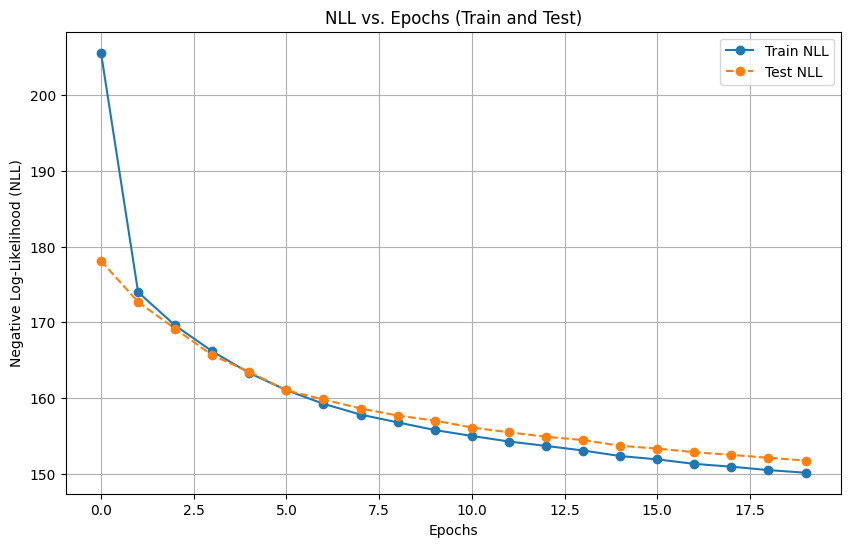

In [ ]:
n_epochs = 20
test_key = random.PRNGKey(10)

nll_train_list = []
nll_test_list = []

for epoch in range(n_epochs):
    print("Epoch: ", epoch)
    opt_state, nll_train = epoch_step(epoch, training_generator, opt_state)
    nll_train_list.append(nll_train)
    nll_test = evaluate(opt_state, test_images, test_key)
    nll_test_list.append(nll_test)
    print(f"Train NLL: {nll_train}")
    print("Test NLL: ", nll_test, '\n')

# Plotting NLL vs. epochs
plt.figure(figsize=(10, 6))
plt.plot(range(n_epochs), nll_train_list, label='Train NLL', marker='o')
plt.plot(range(n_epochs), nll_test_list, label='Test NLL', marker='o', linestyle='--')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Negative Log-Likelihood (NLL)')
plt.title('NLL vs. Epochs (Train and Test)')
plt.legend()
plt.grid()
plt.show()

### Task 3: Experiments

Let's put the trained VAE to use by visulizing the latent space and sampling synthetic data. Complete the following code snippets to do so.
**Visualize the latent space. Use the labels $y$ to color the latent representations in a scatter plot.**

Hint: Encode the training or test set, and use `plt.scatter`.

In [ ]:
def show_latent_space():
  encoder_params = get_params(opt_state)[0]
  (mu, sigma), z, bernoulli_theta = forward((encoder_params, []), test_images, test_key)
  labels = test_labels
  # Scatter plot of the latent representations
  plt.figure(figsize=(10, 8))
  plt.scatter(z[:, 0], z[:, 1], c=labels, cmap='viridis', alpha=0.5)  # Use the labels for coloring
  plt.colorbar(label='Labels')
  plt.xlabel('Latent Dimension 1')
  plt.ylabel('Latent Dimension 2')
  plt.title('Latent Space Visualization')
  plt.grid(True)
  plt.show()
  pass

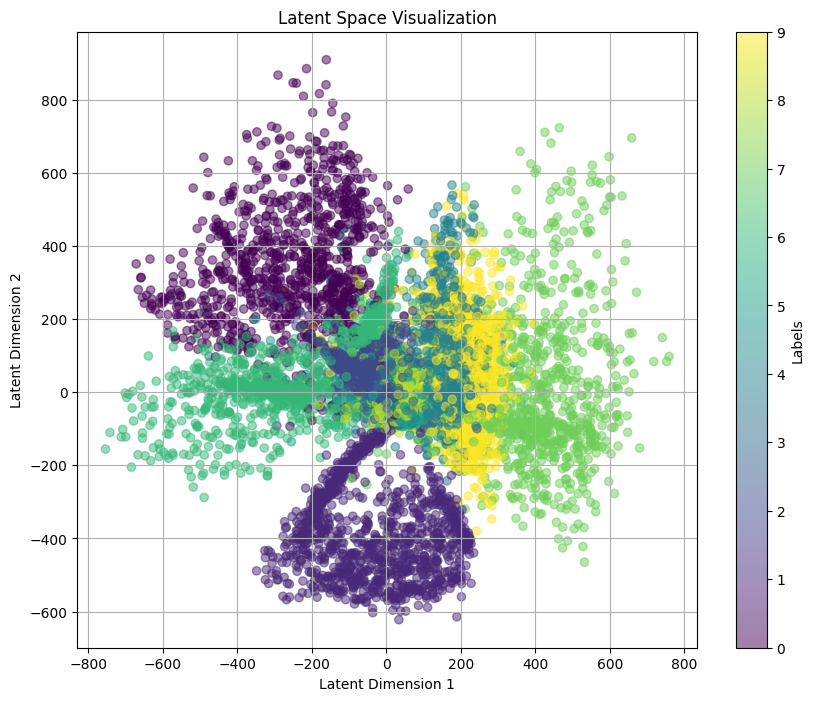

In [ ]:
show_latent_space()

Monitor the reconstruction quality of your model. Visualize a single input image together its reconstruction.

In [ ]:
def reconstruct_an_image():
  # reconstruct_an_image()
  x = test_images[10]  # the image to be reconstructed
  opt_params = get_params(opt_state)
  # call the forwad function and use its output to reconstruct the image
  (mu, sigma), z, bernoulli_theta = forward(opt_params, x, random.PRNGKey(10))
  z_sampled = sample(random.PRNGKey(10), mu, sigma)
  decoded_image = decode(opt_params[1], z_sampled)

  plt.figure(figsize=(8, 4))
  plt.subplot(1, 2, 1)
  plt.imshow(x.reshape(28, 28), cmap='gray')
  plt.title('Original Image')
  plt.axis('off')

  plt.subplot(1, 2, 2)
  plt.imshow(decoded_image.reshape(28, 28), cmap='gray')
  plt.title('Reconstructed Image')
  plt.axis('off')

  plt.show()

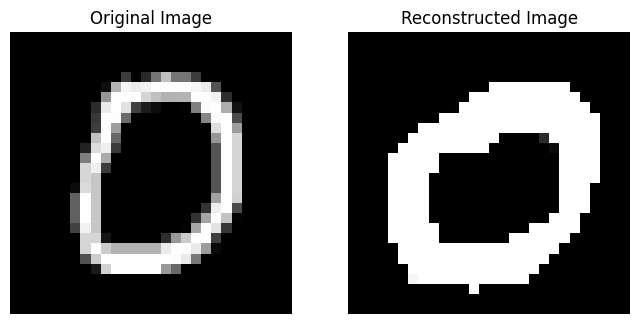

In [ ]:
reconstruct_an_image()

**Generate synthetic data.** Hint: sample $z\sim p(z)$ or "walk" in the latent space. Decode the $z$ you sample/visit and plot the decoded image. Think about what output you expect when you sample from 1) a Bernoulli distribution, or 2) regard the Bernoulli parameter as the sample.

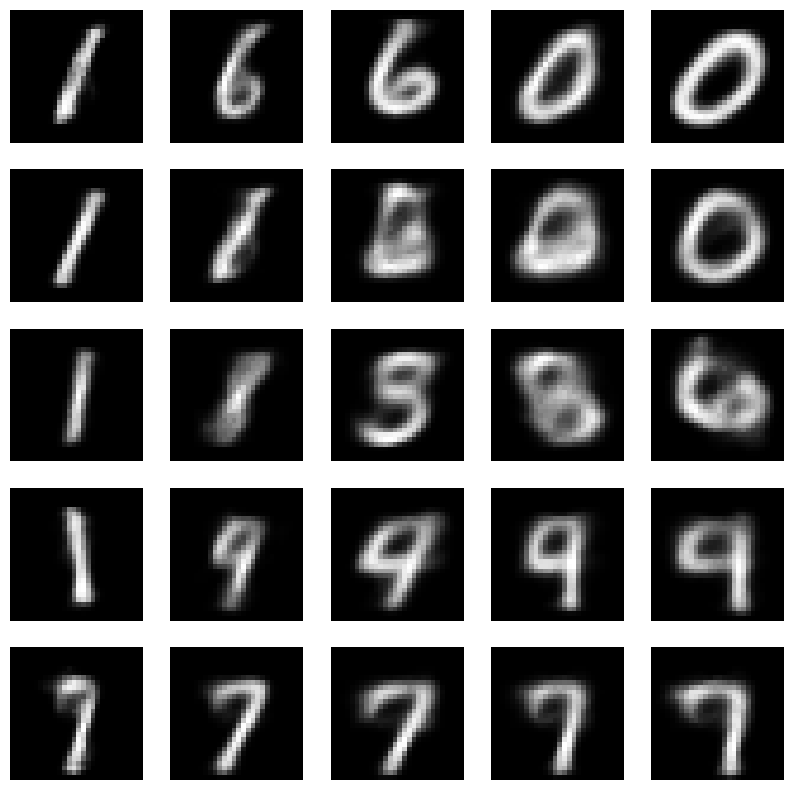

In [ ]:
opt_params=get_params(opt_state)

def plot_grid(decoder_params, grid_size=5, latent_dim=2, range_val=2.0):

    # Create a grid of z values between -range_val and +range_val
    z_vals = np.linspace(-range_val, range_val, grid_size)

    # Initialize an empty list to hold the decoded images
    images = []
    for z1 in z_vals:
        row_images = []
        for z2 in z_vals:
            z = jnp.array([z1, z2])
            sampled_image = decode(opt_params[1], z)
            row_images.append(sampled_image.reshape(28, 28))
        images.append(row_images)

    fig, axs = plt.subplots(len(images), len(images[0]), figsize=(10, 10))

    for i, row in enumerate(images):
        for j, image in enumerate(row):
            axs[i, j].imshow(image, cmap='gray')
            axs[i, j].axis('off')

    plt.show()

plot_grid(opt_params[1])

## $\beta$-VAE

The $\beta$-VAE was proposed by [Higgins et al.](https://openreview.net/pdf?id=Sy2fzU9gl) in 2017 and is a straightforward but important extension of the VAE. In terms of architecture, $\beta$-VAE and VAE are indistinguishable. In fact, the novelty in the work by Higgins et al. lies in a minor modification of the ELBO objective, the $\beta$-objective

$\mathcal{L}_\beta = \mathbb{E}_{q_\phi(z|x)}[\log p_\theta(x|z)] - \beta \mathbb{E}_{q_\phi(z|x)}[\log \frac{q_\phi(z|x)}{p(z)}]$,

where $\beta\geq0$ is a hyperparameter weighting the KL divergence

KL$(q_\phi(z|x)\Vert p(z)) = \mathbb{E}_{q_\phi(z|x)}[\log \frac{q_\phi(z|x)}{p(z)}]$. Observe that we retrieve the standard ELBO when $\beta=1$.

This objective is useful for

* emphasizing high-fidelity reconstructions *or* disentangling the latent space
* obtaining an increased interpretability
* doing KL warm-up.

The effects of the $\beta$-objective are mostly visible asymptotically, why we may not experience the full power of it here (e.g., [NVAE](https://arxiv.org/pdf/2007.03898.pdf) applies KL warm-up during the *first 25k iterations*).

However, plenty of the state-of-the-art VAEs (in terms of density estimation) apply KL warm-up (e.g. NVAE, [VampPrior](https://arxiv.org/pdf/1705.07120.pdf), [LadderVAE](https://arxiv.org/pdf/1602.02282.pdf); see LadderVAE for a nice motivation of KL warm-up), so it is good to know. Also, aside from being very straightforward to implement, the $\beta$-objective leads us to the following important note.

**Important note**: as pointed out by [Hoffman et al.](http://bayesiandeeplearning.org/2017/papers/66.pdf), the $\beta$-objective shown above cannot be considered an evidence lower-bound. Hence, test scores based on the $\beta$-objective **should not be used for benchmarking against proper marginal log-likelihood estimates (such as the ELBO)**. If you are interested, try to reverse the derivations of the ELBO in [1] while including $\beta$.

### Task 4: $\beta$-ELBO

**Compute the $\beta$-objective in the following function.**

Hint: this should require minimal changes to the ```get_elbo```
function above. Also, observe that



$\mathcal{L}_\beta \simeq \frac{1}{L}\sum_l \log p_\theta(x|z_l)-\beta\log\frac{q_\phi(z_l|x)}{p(z_l)}$.


In [ ]:
@jit
def get_beta_elbo(params, x, rng, beta):
    # the negative elbo should be a scalar value, i.e. averaged over the mini-batch.
    (mu, sigma), z, bernoulli_theta = forward(params, x, rng)
    # write code to compute the ELBO
    log_px_z = tfp.distributions.Bernoulli(probs=bernoulli_theta).log_prob(x).sum(axis=-1) # log p_theta(x|z)
    kl_divergence =-0.5 * beta * jnp.sum(1 + jnp.log(jnp.square(sigma)) - jnp.square(mu) - jnp.square(sigma), axis=-1)
    beta_elbo = jnp.mean(log_px_z - kl_divergence)
    return -beta_elbo

Now we define ```epoch_step_beta``` that calls ```get_beta_elbo``` instead of ```get_elbo```, and so that it can take a $\beta\geq 0$ as input.

In [ ]:
def epoch_step_beta(epoch, training_generator, opt_state, beta):
    # an rng, random number generator, is required for all stochastic operations
    rng = random.PRNGKey(epoch)
    nlls = []
    for i, (x, y) in enumerate(tqdm(training_generator)):
        x = jax.device_put(x) / 255
        value, grads = jax.value_and_grad(get_beta_elbo)(get_params(opt_state),
                                                         x,
                                                         rng,
                                                         beta)
        opt_state = opt_update(i,
                               grads,
                               opt_state)
        nlls.append(value)
    return opt_state, np.mean(nlls)

Again, importantly, we have used $\beta=1$ as default in ```evaluate_beta```, which makes the evaluation scores comparable to those of the standard VAE that we trained above.

In [ ]:
def evaluate_beta(opt_state, x, test_rng,beta=1):
    params = get_params(opt_state)
    x = jax.device_put(x) / 255
    nll = get_beta_elbo(params,
                        x,
                        test_rng,beta)
    return nll

Before retraining the VAE, or $\beta$-VAE, we need to reinitialize the encoder/decoder nets and the optimizer above. This is done by simply running the cell below.

In [ ]:
beta = 5  # just an example for a big beta. Try with other values!
latent_dimensions = 2

# encoder defs
encoder_init, encode = stax.serial(
    Dense(300), Relu,
    Dense(300), Relu,
    FanOut(2),
    stax.parallel(Dense(latent_dimensions), stax.serial(Dense(latent_dimensions), Softplus)),
)

# decoder defs
decoder_init, decode = stax.serial(
    Dense(300), Relu,
    Dense(300), Relu,
    Dense(28 * 28), Sigmoid
)


# initialize networks and get params
enc_init_key, dec_init_key = random.split(random.PRNGKey(100))
_, encoder_params = encoder_init(enc_init_key, input_shape=(-1, 28 * 28))
_, decoder_params = decoder_init(dec_init_key,
                                 input_shape=
                                 (-1, latent_dimensions))
params = encoder_params, decoder_params

# initialize optimizer
opt_init, opt_update, get_params = optimizers.adam(step_size=0.001)
opt_state = opt_init(params)

Rerun the experiments section below. Any difference? If you train for a few couple of epochs, then we shouldn't expect huge variations. But perhaps setting $\beta$ to something very big will affect the distribution of $z$'s in the latent space? Does setting $\beta=0$ affect the fidelity of the reconstructed image? Why would we, at least asymptotically, expect these effects?

### Task 4: $\beta$-Experiments

In [ ]:
n_epochs = 20
train_key,test_key = random.split(random.PRNGKey(10))
for epoch in range(n_epochs):
    print("Epoch: ", epoch)
    opt_state, nll_train = epoch_step_beta(epoch,
                                           training_generator,
                                           opt_state,
                                           beta)
    nll_test = evaluate_beta(opt_state,
                             test_images,
                             test_key)
    print("Train NLL: ", nll_train)
    print("Test NLL: ", nll_test)

Epoch:  0


100%|██████████| 242/242 [00:19<00:00, 12.35it/s]


Train NLL:  219.02608
Test NLL:  186.03543
Epoch:  1


100%|██████████| 242/242 [00:16<00:00, 14.83it/s]


Train NLL:  190.0706
Test NLL:  181.32417
Epoch:  2


100%|██████████| 242/242 [00:16<00:00, 14.73it/s]


Train NLL:  187.91106
Test NLL:  179.29407
Epoch:  3


100%|██████████| 242/242 [00:17<00:00, 13.65it/s]


Train NLL:  186.17085
Test NLL:  177.19183
Epoch:  4


100%|██████████| 242/242 [00:16<00:00, 14.84it/s]


Train NLL:  184.59024
Test NLL:  174.5694
Epoch:  5


100%|██████████| 242/242 [00:16<00:00, 14.69it/s]


Train NLL:  183.10318
Test NLL:  172.75699
Epoch:  6


100%|██████████| 242/242 [00:16<00:00, 14.36it/s]


Train NLL:  181.67378
Test NLL:  170.28537
Epoch:  7


100%|██████████| 242/242 [00:17<00:00, 14.13it/s]


Train NLL:  179.84279
Test NLL:  168.98575
Epoch:  8


100%|██████████| 242/242 [00:16<00:00, 14.70it/s]


Train NLL:  178.88449
Test NLL:  167.38766
Epoch:  9


100%|██████████| 242/242 [00:16<00:00, 14.73it/s]


Train NLL:  177.61101
Test NLL:  166.17729
Epoch:  10


100%|██████████| 242/242 [00:17<00:00, 13.77it/s]


Train NLL:  176.8377
Test NLL:  166.09142
Epoch:  11


100%|██████████| 242/242 [00:16<00:00, 14.62it/s]


Train NLL:  176.04158
Test NLL:  164.7556
Epoch:  12


100%|██████████| 242/242 [00:16<00:00, 14.83it/s]


Train NLL:  175.78131
Test NLL:  163.2002
Epoch:  13


100%|██████████| 242/242 [00:16<00:00, 14.73it/s]


Train NLL:  175.42216
Test NLL:  162.74088
Epoch:  14


100%|██████████| 242/242 [00:19<00:00, 12.25it/s]


Train NLL:  174.35664
Test NLL:  162.9661
Epoch:  15


100%|██████████| 242/242 [00:16<00:00, 14.36it/s]


Train NLL:  174.3605
Test NLL:  161.82454
Epoch:  16


100%|██████████| 242/242 [00:16<00:00, 14.49it/s]


Train NLL:  173.48434
Test NLL:  161.80283
Epoch:  17


100%|██████████| 242/242 [00:17<00:00, 13.50it/s]


Train NLL:  173.4755
Test NLL:  160.67975
Epoch:  18


100%|██████████| 242/242 [00:16<00:00, 14.41it/s]


Train NLL:  172.9979
Test NLL:  160.07202
Epoch:  19


100%|██████████| 242/242 [00:16<00:00, 14.65it/s]


Train NLL:  173.07262
Test NLL:  159.65497


What has changed in the latent space? Try playing with a few values of $\beta$ and explain what affects the change in the latent space?

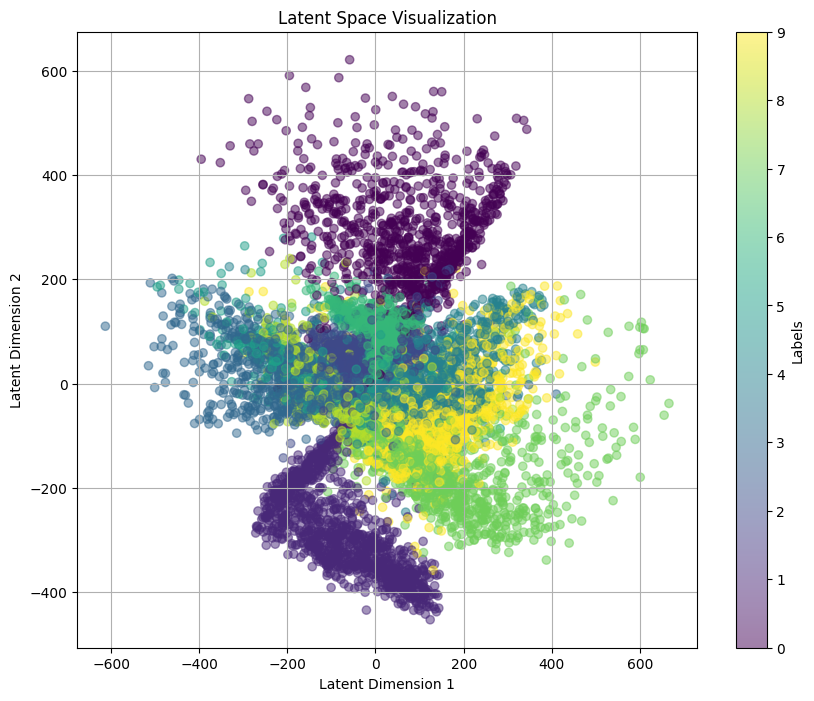

In [ ]:
# visualize the latent space
show_latent_space()

What about the reconstruction quality of your model? Has it improved or degraded?

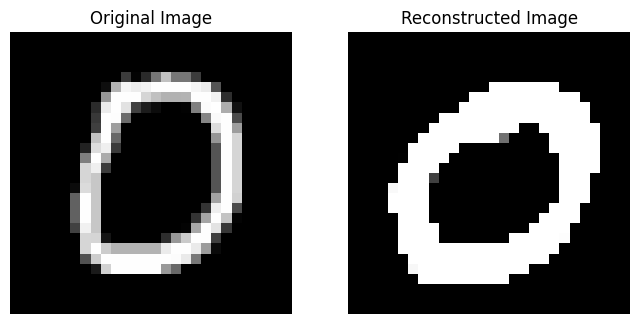

In [ ]:
# reconstruct an image
reconstruct_an_image()

Sample from the latent space and decode. Do you see any difference?

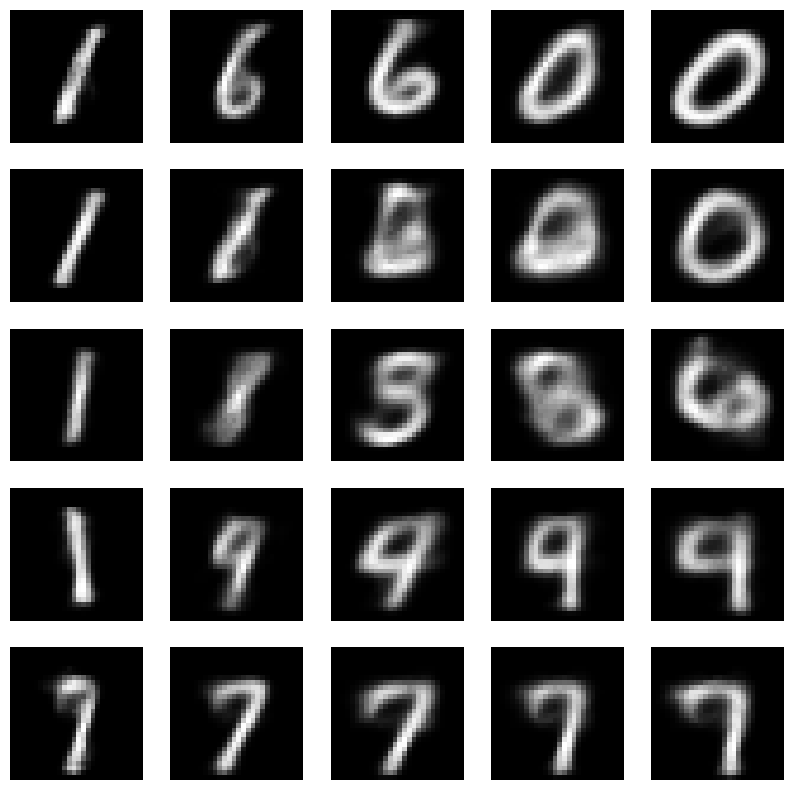

In [ ]:
# sample a few images
opt_beta_params=get_params(opt_state)
plot_grid(opt_beta_params[1])

## Importance Weigthed Auto-Encoder (IWAE)


Similarily as for $\beta$-VAE, the distinguishing factor between the VAE and [IWAE](https://arxiv.org/abs/1509.00519) is the alternative objective function, the importance weighted ELBO (IWELBO):

$\mathcal{L}_{K} = \mathbb{E}_{q_\phi(z|x)}\left[\log\frac{1}{K}\sum_k\frac{p_\theta(x|z_k)p(z_k)}{q_\phi(z_k|x)}\right]$.

When computing $\mathcal{L}_{K}$ in contrast to the ELBO, we sample $K$ latent representations instead of one. Although this might seem like a simple extension, the IWELBO has huge implications on the field of VAEs, *as well as* the VI literature in general (see e.g. [Domke and Sheldon](https://arxiv.org/pdf/1808.09034.pdf)). Specifically (n.b., *not an exhaustive list*),

* it is a proper lower-bound on the marginal log-likelihood.
* it is an effective way of improving the NLL test scores (used by state-of-the-art VAEs when reporting NLL scores, including those mentioned above).

The former bullet implies that we *can* use IWELBO to benchmark our VAE against other VAEs, in contrast to the $\beta$-objective. The latter bullet implies that we probably *should* use it when benchmarking. Because, accoring to  Theorem 1 in the IWAE paper, the marginal log-likelihood estimates are montonically increasing with $K$, meaning that

$\mathcal{L}_{K}\geq \mathcal{L}_{K-1}\geq \mathcal{L}$.

### Task 5: IWELBO

Modify the following functions such that $K$ samples are drawn instead of 1. Then compute the IWELBO.

In [ ]:
@partial(jax.jit, static_argnames=['K'])
def sample_K(rng, mu, std, K):
  # use the reparameterization trick and sample K latent variables rather than 1

  mu_exp = jnp.repeat(mu[:, jnp.newaxis, :], K, axis = 1)
  std_exp = jnp.repeat(std[:, jnp.newaxis, :], K, axis = 1) #(248, K, 2)
  epsilon = jax.random.normal(rng, mu_exp.shape)
  z = mu_exp + epsilon * std_exp
  print(z.shape)
  return z

In [ ]:
@partial(jax.jit, static_argnames=['K'])
def forward_K(params, x, rng, K):
    encoder_params, decoder_params = params
    phi = encode(encoder_params, inputs=x)
    z = sample_K(rng,
            mu=phi[0],
            std=phi[1],
            K=K)
    bernoulli_theta = decode(decoder_params, z)
    return phi, z, bernoulli_theta

In [ ]:
from jax.scipy.special import logsumexp

@partial(jax.jit, static_argnames=['K'])
def get_iw_elbo(params, x, rng, K):
    # the negative elbo should be a scalar value, i.e. averaged over the mini-batch.
    (mu, sigma), z, bernoulli_theta = forward_K(params, x, rng, K)
    # hint: use the logsumexp() operation over K (available in the jax library)
    # and subtract with logK to do the average inside the log.
    x_exp = jnp.repeat(x[:, jnp.newaxis, :], K, axis = 1)
    log_px_z = jnp.sum(tfp.distributions.Bernoulli(probs=bernoulli_theta).log_prob(x_exp),axis=-1)
    kl_divergence = -0.5 * jnp.sum(1 + 2 * jnp.log(sigma) - jnp.square(mu) - jnp.square(sigma), axis=-1)
    kl_divergence_exp = jnp.repeat(kl_divergence[:, jnp.newaxis], K, axis=1)
    log_weights = log_px_z - kl_divergence_exp

    iwelbo = jnp.mean(logsumexp(log_weights, axis=-1) - jnp.log(K))

    return -iwelbo

In [ ]:
def epoch_step_K(epoch, training_generator, opt_state,beta):
    # an rng, random number generator, is required for all stochastic operations
    rng = random.PRNGKey(epoch)
    nlls = []
    for i, (x, y) in enumerate(tqdm(training_generator)):
        x = jax.device_put(x) / 255
        value, grads = jax.value_and_grad(get_iw_elbo)(get_params(opt_state),
                                                         x,
                                                         rng,
                                                         K)
        opt_state = opt_update(i,
                               grads,
                               opt_state)
        nlls.append(value)
    return opt_state, np.mean(nlls)

In [ ]:
def evaluate_K(opt_state, x, test_rng, K):
    params = get_params(opt_state)
    x = jax.device_put(x) / 255.0
    params, x = jax.lax.stop_gradient(params), jax.lax.stop_gradient(x)
    nll = get_iw_elbo(params, x, test_rng, K)
    return nll

Again, we need to re-initialize the network and optimizer states.

In [ ]:
K = 4  # try with different values ranging from 1 to 10
latent_dimensions = 2

# encoder defs
encoder_init, encode = stax.serial(
    Dense(300), Relu,
    Dense(300), Relu,
    FanOut(2),
    stax.parallel(Dense(latent_dimensions), stax.serial(Dense(latent_dimensions), Softplus)),
)

# decoder defs
decoder_init, decode = stax.serial(
    Dense(300), Relu,
    Dense(300), Relu,
    Dense(28 * 28), Sigmoid
)


# initialize networks and get params
enc_init_key, dec_init_key = random.split(random.PRNGKey(100))
_, encoder_params = encoder_init(enc_init_key, input_shape=(-1, 28 * 28))
_, decoder_params = decoder_init(dec_init_key,
                                 input_shape=
                                 (-1, latent_dimensions))
params = encoder_params, decoder_params

# initialize optimizer
opt_init, opt_update, get_params = optimizers.adam(step_size=0.0001)  # this time we use a smaller learning rate due to numerical stability
opt_state = opt_init(params)

In [ ]:
n_epochs = 20
test_key = random.PRNGKey(10)
nll_train_K=[]
nll_test_K=[]

for K in range(1, 11):
  #initialize every loop
  nll_train_list = []
  nll_test_list = []
  opt_init, opt_update, get_params = optimizers.adam(step_size=0.0001)
  opt_state = opt_init(params)

  for epoch in range(n_epochs):
      print("Epoch: ", epoch)
      opt_state, nll_train = epoch_step_K(epoch,
                                        training_generator,
                                        opt_state,
                                        K)
      nll_test = evaluate_K(opt_state, test_images, test_key, K)
      nll_train_list.append(nll_train)
      nll_test_list.append(nll_test)
      print("Train NLL: ", nll_train)
      print("Test NLL: ", nll_test)
  nll_train_K.append(nll_train_list)
  nll_test_K.append(nll_test_list)

Epoch:  0


  0%|          | 0/242 [00:00<?, ?it/s]

(248, 1, 2)


100%|█████████▉| 241/242 [00:19<00:00, 15.69it/s]

(232, 1, 2)


100%|██████████| 242/242 [00:20<00:00, 11.87it/s]


(10000, 1, 2)
Train NLL:  303.7843
Test NLL:  215.49727
Epoch:  1


100%|██████████| 242/242 [00:16<00:00, 14.38it/s]


Train NLL:  211.2568
Test NLL:  207.48155
Epoch:  2


100%|██████████| 242/242 [00:17<00:00, 14.10it/s]


Train NLL:  205.93143
Test NLL:  203.89082
Epoch:  3


100%|██████████| 242/242 [00:17<00:00, 13.53it/s]


Train NLL:  201.78108
Test NLL:  197.36319
Epoch:  4


100%|██████████| 242/242 [00:16<00:00, 14.50it/s]


Train NLL:  195.4216
Test NLL:  192.38089
Epoch:  5


100%|██████████| 242/242 [00:16<00:00, 14.50it/s]


Train NLL:  191.63916
Test NLL:  189.25739
Epoch:  6


100%|██████████| 242/242 [00:18<00:00, 13.23it/s]


Train NLL:  188.83952
Test NLL:  186.98117
Epoch:  7


100%|██████████| 242/242 [00:16<00:00, 14.38it/s]


Train NLL:  186.86368
Test NLL:  185.33022
Epoch:  8


100%|██████████| 242/242 [00:16<00:00, 14.38it/s]


Train NLL:  185.3752
Test NLL:  183.81769
Epoch:  9


100%|██████████| 242/242 [00:18<00:00, 13.36it/s]


Train NLL:  183.86629
Test NLL:  182.13013
Epoch:  10


100%|██████████| 242/242 [00:16<00:00, 14.40it/s]


Train NLL:  182.17125
Test NLL:  180.30238
Epoch:  11


100%|██████████| 242/242 [00:16<00:00, 14.41it/s]


Train NLL:  180.53958
Test NLL:  178.8529
Epoch:  12


100%|██████████| 242/242 [00:17<00:00, 14.16it/s]


Train NLL:  179.36646
Test NLL:  177.74443
Epoch:  13


100%|██████████| 242/242 [00:17<00:00, 13.79it/s]


Train NLL:  178.4385
Test NLL:  176.90025
Epoch:  14


100%|██████████| 242/242 [00:16<00:00, 14.34it/s]


Train NLL:  177.56224
Test NLL:  176.23839
Epoch:  15


100%|██████████| 242/242 [00:16<00:00, 14.38it/s]


Train NLL:  177.00992
Test NLL:  175.65619
Epoch:  16


100%|██████████| 242/242 [00:18<00:00, 13.39it/s]


Train NLL:  176.35808
Test NLL:  175.12093
Epoch:  17


100%|██████████| 242/242 [00:16<00:00, 14.29it/s]


Train NLL:  175.9086
Test NLL:  174.68681
Epoch:  18


100%|██████████| 242/242 [00:16<00:00, 14.26it/s]


Train NLL:  175.39563
Test NLL:  174.21696
Epoch:  19


100%|██████████| 242/242 [00:18<00:00, 13.41it/s]


Train NLL:  174.99385
Test NLL:  173.7739
Epoch:  0


  0%|          | 0/242 [00:00<?, ?it/s]

(248, 2, 2)


 99%|█████████▉| 240/242 [00:20<00:00, 13.14it/s]

(232, 2, 2)


100%|██████████| 242/242 [00:22<00:00, 10.96it/s]


(10000, 2, 2)
Train NLL:  299.3073
Test NLL:  213.5895
Epoch:  1


100%|██████████| 242/242 [00:20<00:00, 11.66it/s]


Train NLL:  209.90315
Test NLL:  205.63753
Epoch:  2


100%|██████████| 242/242 [00:20<00:00, 11.92it/s]


Train NLL:  203.15146
Test NLL:  198.30539
Epoch:  3


100%|██████████| 242/242 [00:20<00:00, 11.70it/s]


Train NLL:  195.678
Test NLL:  192.14603
Epoch:  4


100%|██████████| 242/242 [00:21<00:00, 11.35it/s]


Train NLL:  191.1249
Test NLL:  188.92952
Epoch:  5


100%|██████████| 242/242 [00:19<00:00, 12.28it/s]


Train NLL:  188.56705
Test NLL:  186.91331
Epoch:  6


100%|██████████| 242/242 [00:21<00:00, 11.44it/s]


Train NLL:  186.87439
Test NLL:  185.49472
Epoch:  7


100%|██████████| 242/242 [00:20<00:00, 12.03it/s]


Train NLL:  185.61491
Test NLL:  184.33302
Epoch:  8


100%|██████████| 242/242 [00:21<00:00, 11.46it/s]


Train NLL:  184.57274
Test NLL:  183.17307
Epoch:  9


100%|██████████| 242/242 [00:19<00:00, 12.25it/s]


Train NLL:  183.49086
Test NLL:  181.8631
Epoch:  10


100%|██████████| 242/242 [00:20<00:00, 11.72it/s]


Train NLL:  182.0116
Test NLL:  180.23302
Epoch:  11


100%|██████████| 242/242 [00:20<00:00, 11.65it/s]


Train NLL:  180.51616
Test NLL:  178.58846
Epoch:  12


100%|██████████| 242/242 [00:19<00:00, 12.21it/s]


Train NLL:  179.05617
Test NLL:  177.30115
Epoch:  13


100%|██████████| 242/242 [00:20<00:00, 11.55it/s]


Train NLL:  177.93207
Test NLL:  176.3504
Epoch:  14


100%|██████████| 242/242 [00:19<00:00, 12.17it/s]


Train NLL:  176.99918
Test NLL:  175.58331
Epoch:  15


100%|██████████| 242/242 [00:21<00:00, 11.43it/s]


Train NLL:  176.31372
Test NLL:  174.92291
Epoch:  16


100%|██████████| 242/242 [00:19<00:00, 12.18it/s]


Train NLL:  175.58488
Test NLL:  174.31732
Epoch:  17


100%|██████████| 242/242 [00:21<00:00, 11.51it/s]


Train NLL:  174.94102
Test NLL:  173.76007
Epoch:  18


100%|██████████| 242/242 [00:19<00:00, 12.28it/s]


Train NLL:  174.4878
Test NLL:  173.21599
Epoch:  19


100%|██████████| 242/242 [00:20<00:00, 11.62it/s]


Train NLL:  173.80359
Test NLL:  172.71924
Epoch:  0


  0%|          | 0/242 [00:00<?, ?it/s]

(248, 3, 2)


 99%|█████████▉| 240/242 [00:24<00:00, 11.75it/s]

(232, 3, 2)


100%|██████████| 242/242 [00:25<00:00,  9.34it/s]


(10000, 3, 2)
Train NLL:  295.56516
Test NLL:  211.8387
Epoch:  1


100%|██████████| 242/242 [00:23<00:00, 10.19it/s]


Train NLL:  207.26215
Test NLL:  202.21288
Epoch:  2


100%|██████████| 242/242 [00:22<00:00, 10.84it/s]


Train NLL:  198.2458
Test NLL:  193.693
Epoch:  3


100%|██████████| 242/242 [00:23<00:00, 10.51it/s]


Train NLL:  192.0971
Test NLL:  189.51158
Epoch:  4


100%|██████████| 242/242 [00:23<00:00, 10.24it/s]


Train NLL:  188.77583
Test NLL:  187.12144
Epoch:  5


100%|██████████| 242/242 [00:23<00:00, 10.14it/s]


Train NLL:  186.93153
Test NLL:  185.58366
Epoch:  6


100%|██████████| 242/242 [00:24<00:00,  9.95it/s]


Train NLL:  185.57126
Test NLL:  184.46355
Epoch:  7


100%|██████████| 242/242 [00:22<00:00, 10.83it/s]


Train NLL:  184.68198
Test NLL:  183.46297
Epoch:  8


100%|██████████| 242/242 [00:23<00:00, 10.33it/s]


Train NLL:  183.69185
Test NLL:  182.53465
Epoch:  9


100%|██████████| 242/242 [00:23<00:00, 10.24it/s]


Train NLL:  182.77827
Test NLL:  181.46198
Epoch:  10


100%|██████████| 242/242 [00:23<00:00, 10.16it/s]


Train NLL:  181.6403
Test NLL:  180.00812
Epoch:  11


100%|██████████| 242/242 [00:23<00:00, 10.39it/s]


Train NLL:  180.10666
Test NLL:  178.38115
Epoch:  12


100%|██████████| 242/242 [00:22<00:00, 10.73it/s]


Train NLL:  178.70737
Test NLL:  177.07343
Epoch:  13


100%|██████████| 242/242 [00:23<00:00, 10.20it/s]


Train NLL:  177.52751
Test NLL:  176.11542
Epoch:  14


100%|██████████| 242/242 [00:23<00:00, 10.18it/s]


Train NLL:  176.56401
Test NLL:  175.37787
Epoch:  15


100%|██████████| 242/242 [00:23<00:00, 10.22it/s]


Train NLL:  175.92336
Test NLL:  174.7264
Epoch:  16


100%|██████████| 242/242 [00:22<00:00, 10.88it/s]


Train NLL:  175.28598
Test NLL:  174.15254
Epoch:  17


100%|██████████| 242/242 [00:23<00:00, 10.45it/s]


Train NLL:  174.69452
Test NLL:  173.58362
Epoch:  18


100%|██████████| 242/242 [00:23<00:00, 10.15it/s]


Train NLL:  174.0528
Test NLL:  173.01936
Epoch:  19


100%|██████████| 242/242 [00:23<00:00, 10.14it/s]


Train NLL:  173.4258
Test NLL:  172.49509
Epoch:  0


  0%|          | 0/242 [00:00<?, ?it/s]

(248, 4, 2)


100%|█████████▉| 241/242 [00:27<00:00, 10.38it/s]

(232, 4, 2)


100%|██████████| 242/242 [00:29<00:00,  8.34it/s]


(10000, 4, 2)
Train NLL:  294.7114
Test NLL:  212.96025
Epoch:  1


100%|██████████| 242/242 [00:26<00:00,  9.12it/s]


Train NLL:  208.28351
Test NLL:  203.31886
Epoch:  2


100%|██████████| 242/242 [00:26<00:00,  9.15it/s]


Train NLL:  199.46881
Test NLL:  194.38489
Epoch:  3


100%|██████████| 242/242 [00:26<00:00,  9.12it/s]


Train NLL:  192.31662
Test NLL:  189.50839
Epoch:  4


100%|██████████| 242/242 [00:26<00:00,  9.09it/s]


Train NLL:  188.48567
Test NLL:  186.87418
Epoch:  5


100%|██████████| 242/242 [00:26<00:00,  9.02it/s]


Train NLL:  186.33252
Test NLL:  185.2661
Epoch:  6


100%|██████████| 242/242 [00:26<00:00,  9.09it/s]


Train NLL:  185.16182
Test NLL:  184.08891
Epoch:  7


100%|██████████| 242/242 [00:26<00:00,  9.18it/s]


Train NLL:  184.13083
Test NLL:  183.08408
Epoch:  8


100%|██████████| 242/242 [00:26<00:00,  9.10it/s]


Train NLL:  183.20374
Test NLL:  182.11607
Epoch:  9


100%|██████████| 242/242 [00:26<00:00,  9.18it/s]


Train NLL:  182.09846
Test NLL:  180.85944
Epoch:  10


100%|██████████| 242/242 [00:26<00:00,  9.17it/s]


Train NLL:  180.7316
Test NLL:  179.20294
Epoch:  11


100%|██████████| 242/242 [00:26<00:00,  9.22it/s]


Train NLL:  179.0247
Test NLL:  177.566
Epoch:  12


100%|██████████| 242/242 [00:26<00:00,  9.27it/s]


Train NLL:  177.60776
Test NLL:  176.33815
Epoch:  13


100%|██████████| 242/242 [00:26<00:00,  9.29it/s]


Train NLL:  176.59224
Test NLL:  175.40239
Epoch:  14


100%|██████████| 242/242 [00:26<00:00,  9.25it/s]


Train NLL:  175.6662
Test NLL:  174.61131
Epoch:  15


100%|██████████| 242/242 [00:26<00:00,  9.08it/s]


Train NLL:  174.76517
Test NLL:  173.88005
Epoch:  16


100%|██████████| 242/242 [00:26<00:00,  9.17it/s]


Train NLL:  174.02037
Test NLL:  173.19931
Epoch:  17


100%|██████████| 242/242 [00:26<00:00,  9.19it/s]


Train NLL:  173.42143
Test NLL:  172.56062
Epoch:  18


100%|██████████| 242/242 [00:25<00:00,  9.32it/s]


Train NLL:  172.7215
Test NLL:  171.96982
Epoch:  19


100%|██████████| 242/242 [00:26<00:00,  9.30it/s]


Train NLL:  172.19792
Test NLL:  171.44112
Epoch:  0


  0%|          | 0/242 [00:00<?, ?it/s]

(248, 5, 2)


100%|█████████▉| 241/242 [00:31<00:00,  8.78it/s]

(232, 5, 2)


100%|██████████| 242/242 [00:33<00:00,  7.27it/s]


(10000, 5, 2)
Train NLL:  293.6965
Test NLL:  211.34514
Epoch:  1


100%|██████████| 242/242 [00:31<00:00,  7.78it/s]


Train NLL:  205.41953
Test NLL:  198.71335
Epoch:  2


100%|██████████| 242/242 [00:30<00:00,  7.97it/s]


Train NLL:  195.60553
Test NLL:  191.35655
Epoch:  3


100%|██████████| 242/242 [00:30<00:00,  7.94it/s]


Train NLL:  189.80127
Test NLL:  187.5826
Epoch:  4


100%|██████████| 242/242 [00:31<00:00,  7.63it/s]


Train NLL:  187.00749
Test NLL:  185.54767
Epoch:  5


100%|██████████| 242/242 [00:30<00:00,  7.94it/s]


Train NLL:  185.44092
Test NLL:  184.07172
Epoch:  6


100%|██████████| 242/242 [00:30<00:00,  7.99it/s]


Train NLL:  184.0869
Test NLL:  182.7692
Epoch:  7


100%|██████████| 242/242 [00:31<00:00,  7.65it/s]


Train NLL:  182.81792
Test NLL:  181.2217
Epoch:  8


100%|██████████| 242/242 [00:30<00:00,  8.00it/s]


Train NLL:  180.93993
Test NLL:  179.1001
Epoch:  9


100%|██████████| 242/242 [00:30<00:00,  7.90it/s]


Train NLL:  179.01491
Test NLL:  177.43973
Epoch:  10


100%|██████████| 242/242 [00:31<00:00,  7.78it/s]


Train NLL:  177.6919
Test NLL:  176.26602
Epoch:  11


100%|██████████| 242/242 [00:30<00:00,  7.94it/s]


Train NLL:  176.65685
Test NLL:  175.38565
Epoch:  12


100%|██████████| 242/242 [00:30<00:00,  7.88it/s]


Train NLL:  175.81088
Test NLL:  174.6361
Epoch:  13


100%|██████████| 242/242 [00:30<00:00,  7.92it/s]


Train NLL:  175.0783
Test NLL:  173.95447
Epoch:  14


100%|██████████| 242/242 [00:30<00:00,  7.99it/s]


Train NLL:  174.33878
Test NLL:  173.3289
Epoch:  15


100%|██████████| 242/242 [00:31<00:00,  7.80it/s]


Train NLL:  173.6641
Test NLL:  172.69284
Epoch:  16


100%|██████████| 242/242 [00:30<00:00,  7.99it/s]


Train NLL:  nan
Test NLL:  nan
Epoch:  17


100%|██████████| 242/242 [00:30<00:00,  8.04it/s]


Train NLL:  nan
Test NLL:  nan
Epoch:  18


100%|██████████| 242/242 [00:31<00:00,  7.62it/s]


Train NLL:  nan
Test NLL:  nan
Epoch:  19


100%|██████████| 242/242 [00:30<00:00,  7.95it/s]


Train NLL:  nan
Test NLL:  nan
Epoch:  0


  0%|          | 0/242 [00:00<?, ?it/s]

(248, 6, 2)


100%|█████████▉| 241/242 [00:36<00:00,  6.95it/s]

(232, 6, 2)


100%|██████████| 242/242 [00:37<00:00,  6.42it/s]


(10000, 6, 2)
Train NLL:  291.01395
Test NLL:  209.8916
Epoch:  1


100%|██████████| 242/242 [00:34<00:00,  7.09it/s]


Train NLL:  203.73267
Test NLL:  197.45334
Epoch:  2


100%|██████████| 242/242 [00:34<00:00,  7.10it/s]


Train NLL:  195.06024
Test NLL:  191.61243
Epoch:  3


100%|██████████| 242/242 [00:35<00:00,  6.86it/s]


Train NLL:  189.90944
Test NLL:  187.1156
Epoch:  4


100%|██████████| 242/242 [00:34<00:00,  7.09it/s]


Train NLL:  186.30809
Test NLL:  184.68724
Epoch:  5


100%|██████████| 242/242 [00:34<00:00,  6.93it/s]


Train NLL:  184.37856
Test NLL:  182.99376
Epoch:  6


100%|██████████| 242/242 [00:35<00:00,  6.83it/s]


Train NLL:  182.69612
Test NLL:  181.33727
Epoch:  7


100%|██████████| 242/242 [00:34<00:00,  7.05it/s]


Train NLL:  180.99994
Test NLL:  179.43835
Epoch:  8


100%|██████████| 242/242 [00:34<00:00,  7.00it/s]


Train NLL:  179.26906
Test NLL:  177.81192
Epoch:  9


100%|██████████| 242/242 [00:35<00:00,  6.84it/s]


Train NLL:  177.8197
Test NLL:  176.57805
Epoch:  10


100%|██████████| 242/242 [00:33<00:00,  7.12it/s]


Train NLL:  176.72786
Test NLL:  175.61685
Epoch:  11


100%|██████████| 242/242 [00:35<00:00,  6.89it/s]


Train NLL:  175.83846
Test NLL:  174.82823
Epoch:  12


100%|██████████| 242/242 [00:35<00:00,  6.83it/s]


Train NLL:  175.0677
Test NLL:  174.10262
Epoch:  13


100%|██████████| 242/242 [00:34<00:00,  7.11it/s]


Train NLL:  174.32002
Test NLL:  173.44012
Epoch:  14


100%|██████████| 242/242 [00:35<00:00,  6.87it/s]


Train NLL:  173.65266
Test NLL:  172.818
Epoch:  15


100%|██████████| 242/242 [00:34<00:00,  6.95it/s]


Train NLL:  172.93796
Test NLL:  172.20024
Epoch:  16


100%|██████████| 242/242 [00:33<00:00,  7.20it/s]


Train NLL:  172.34451
Test NLL:  171.6189
Epoch:  17


100%|██████████| 242/242 [00:35<00:00,  6.87it/s]


Train NLL:  171.72227
Test NLL:  171.06491
Epoch:  18


100%|██████████| 242/242 [00:34<00:00,  6.98it/s]


Train NLL:  171.19606
Test NLL:  170.5394
Epoch:  19


100%|██████████| 242/242 [00:33<00:00,  7.18it/s]


Train NLL:  170.60612
Test NLL:  170.04572
Epoch:  0


  0%|          | 0/242 [00:00<?, ?it/s]

(248, 7, 2)


100%|█████████▉| 241/242 [00:39<00:00,  6.94it/s]

(232, 7, 2)


100%|██████████| 242/242 [00:40<00:00,  5.96it/s]


(10000, 7, 2)
Train NLL:  291.91797
Test NLL:  211.61964
Epoch:  1


100%|██████████| 242/242 [00:38<00:00,  6.31it/s]


Train NLL:  206.68184
Test NLL:  200.14328
Epoch:  2


100%|██████████| 242/242 [00:39<00:00,  6.16it/s]


Train NLL:  196.92976
Test NLL:  193.04027
Epoch:  3


100%|██████████| 242/242 [00:38<00:00,  6.29it/s]


Train NLL:  190.95758
Test NLL:  187.81755
Epoch:  4


100%|██████████| 242/242 [00:38<00:00,  6.30it/s]


Train NLL:  186.63652
Test NLL:  185.00636
Epoch:  5


100%|██████████| 242/242 [00:38<00:00,  6.30it/s]


Train NLL:  184.16158
Test NLL:  182.41002
Epoch:  6


100%|██████████| 242/242 [00:38<00:00,  6.26it/s]


Train NLL:  181.53467
Test NLL:  179.96872
Epoch:  7


100%|██████████| 242/242 [00:38<00:00,  6.34it/s]


Train NLL:  179.54933
Test NLL:  178.23308
Epoch:  8


100%|██████████| 242/242 [00:38<00:00,  6.29it/s]


Train NLL:  178.04575
Test NLL:  176.88347
Epoch:  9


100%|██████████| 242/242 [00:38<00:00,  6.36it/s]


Train NLL:  176.79852
Test NLL:  175.79771
Epoch:  10


100%|██████████| 242/242 [00:37<00:00,  6.47it/s]


Train NLL:  175.80229
Test NLL:  174.87079
Epoch:  11


100%|██████████| 242/242 [00:37<00:00,  6.49it/s]


Train NLL:  174.93915
Test NLL:  174.0788
Epoch:  12


100%|██████████| 242/242 [00:37<00:00,  6.45it/s]


Train NLL:  174.18427
Test NLL:  173.4115
Epoch:  13


100%|██████████| 242/242 [00:38<00:00,  6.30it/s]


Train NLL:  173.41473
Test NLL:  172.70363
Epoch:  14


100%|██████████| 242/242 [00:38<00:00,  6.25it/s]


Train NLL:  172.82048
Test NLL:  172.09477
Epoch:  15


100%|██████████| 242/242 [00:38<00:00,  6.25it/s]


Train NLL:  172.14922
Test NLL:  171.51222
Epoch:  16


100%|██████████| 242/242 [00:39<00:00,  6.17it/s]


Train NLL:  171.52942
Test NLL:  170.93036
Epoch:  17


100%|██████████| 242/242 [00:38<00:00,  6.27it/s]


Train NLL:  170.98643
Test NLL:  170.39479
Epoch:  18


100%|██████████| 242/242 [00:38<00:00,  6.31it/s]


Train NLL:  170.46652
Test NLL:  169.90332
Epoch:  19


100%|██████████| 242/242 [00:38<00:00,  6.32it/s]


Train NLL:  169.92894
Test NLL:  169.40826
Epoch:  0


  0%|          | 0/242 [00:00<?, ?it/s]

(248, 8, 2)


100%|█████████▉| 241/242 [00:41<00:00,  6.47it/s]

(232, 8, 2)


100%|██████████| 242/242 [00:43<00:00,  5.60it/s]


(10000, 8, 2)
Train NLL:  291.2813
Test NLL:  213.38065
Epoch:  1


100%|██████████| 242/242 [00:40<00:00,  5.91it/s]


Train NLL:  208.5811
Test NLL:  200.73286
Epoch:  2


100%|██████████| 242/242 [00:40<00:00,  5.94it/s]


Train NLL:  196.90451
Test NLL:  193.20258
Epoch:  3


100%|██████████| 242/242 [00:41<00:00,  5.90it/s]


Train NLL:  191.30827
Test NLL:  188.58847
Epoch:  4


100%|██████████| 242/242 [00:43<00:00,  5.56it/s]


Train NLL:  187.16953
Test NLL:  185.11885
Epoch:  5


100%|██████████| 242/242 [00:40<00:00,  5.95it/s]


Train NLL:  183.98938
Test NLL:  182.44402
Epoch:  6


100%|██████████| 242/242 [00:40<00:00,  5.96it/s]


Train NLL:  181.6178
Test NLL:  180.55841
Epoch:  7


100%|██████████| 242/242 [00:40<00:00,  6.00it/s]


Train NLL:  180.01276
Test NLL:  179.1156
Epoch:  8


100%|██████████| 242/242 [00:40<00:00,  5.94it/s]


Train NLL:  178.74374
Test NLL:  177.90167
Epoch:  9


100%|██████████| 242/242 [00:40<00:00,  5.96it/s]


Train NLL:  177.6199
Test NLL:  176.8152
Epoch:  10


100%|██████████| 242/242 [00:40<00:00,  5.92it/s]


Train NLL:  176.55388
Test NLL:  175.81012
Epoch:  11


100%|██████████| 242/242 [00:40<00:00,  5.94it/s]


Train NLL:  175.55382
Test NLL:  174.90872
Epoch:  12


100%|██████████| 242/242 [00:41<00:00,  5.89it/s]


Train NLL:  174.72263
Test NLL:  174.06651
Epoch:  13


100%|██████████| 242/242 [00:40<00:00,  5.92it/s]


Train NLL:  173.94292
Test NLL:  173.30878
Epoch:  14


100%|██████████| 242/242 [00:40<00:00,  5.92it/s]


Train NLL:  173.12474
Test NLL:  172.61429
Epoch:  15


100%|██████████| 242/242 [00:40<00:00,  5.92it/s]


Train NLL:  172.41295
Test NLL:  171.99272
Epoch:  16


100%|██████████| 242/242 [00:41<00:00,  5.87it/s]


Train NLL:  171.81415
Test NLL:  171.42332
Epoch:  17


100%|██████████| 242/242 [00:40<00:00,  5.92it/s]


Train NLL:  171.23964
Test NLL:  170.87666
Epoch:  18


100%|██████████| 242/242 [00:40<00:00,  5.92it/s]


Train NLL:  170.69354
Test NLL:  170.35635
Epoch:  19


100%|██████████| 242/242 [00:41<00:00,  5.88it/s]


Train NLL:  170.17154
Test NLL:  169.88255
Epoch:  0


  0%|          | 0/242 [00:00<?, ?it/s]

(248, 9, 2)


100%|█████████▉| 241/242 [00:46<00:00,  3.88it/s]

(232, 9, 2)


100%|██████████| 242/242 [00:48<00:00,  5.02it/s]


(10000, 9, 2)
Train NLL:  289.16153
Test NLL:  212.8853
Epoch:  1


100%|██████████| 242/242 [00:44<00:00,  5.39it/s]


Train NLL:  207.2146
Test NLL:  198.64172
Epoch:  2


100%|██████████| 242/242 [00:45<00:00,  5.31it/s]


Train NLL:  193.95866
Test NLL:  188.70972
Epoch:  3


100%|██████████| 242/242 [00:43<00:00,  5.52it/s]


Train NLL:  187.2674
Test NLL:  185.01073
Epoch:  4


100%|██████████| 242/242 [00:44<00:00,  5.39it/s]


Train NLL:  183.99106
Test NLL:  182.32112
Epoch:  5


100%|██████████| 242/242 [00:43<00:00,  5.50it/s]


Train NLL:  181.66927
Test NLL:  180.36725
Epoch:  6


100%|██████████| 242/242 [00:44<00:00,  5.48it/s]


Train NLL:  179.841
Test NLL:  178.8172
Epoch:  7


100%|██████████| 242/242 [00:44<00:00,  5.44it/s]


Train NLL:  178.32858
Test NLL:  177.41533
Epoch:  8


100%|██████████| 242/242 [00:44<00:00,  5.48it/s]


Train NLL:  177.01534
Test NLL:  176.08153
Epoch:  9


100%|██████████| 242/242 [00:45<00:00,  5.31it/s]


Train NLL:  nan
Test NLL:  nan
Epoch:  10


100%|██████████| 242/242 [00:44<00:00,  5.49it/s]


Train NLL:  nan
Test NLL:  nan
Epoch:  11


100%|██████████| 242/242 [00:44<00:00,  5.46it/s]


Train NLL:  nan
Test NLL:  nan
Epoch:  12


100%|██████████| 242/242 [00:44<00:00,  5.47it/s]


Train NLL:  nan
Test NLL:  nan
Epoch:  13


100%|██████████| 242/242 [00:43<00:00,  5.51it/s]


Train NLL:  nan
Test NLL:  nan
Epoch:  14


100%|██████████| 242/242 [00:45<00:00,  5.36it/s]


Train NLL:  nan
Test NLL:  nan
Epoch:  15


100%|██████████| 242/242 [00:44<00:00,  5.48it/s]


Train NLL:  nan
Test NLL:  nan
Epoch:  16


100%|██████████| 242/242 [00:45<00:00,  5.37it/s]


Train NLL:  nan
Test NLL:  nan
Epoch:  17


100%|██████████| 242/242 [00:44<00:00,  5.48it/s]


Train NLL:  nan
Test NLL:  nan
Epoch:  18


100%|██████████| 242/242 [00:44<00:00,  5.48it/s]


Train NLL:  nan
Test NLL:  nan
Epoch:  19


100%|██████████| 242/242 [00:44<00:00,  5.39it/s]


Train NLL:  nan
Test NLL:  nan
Epoch:  0


  0%|          | 0/242 [00:00<?, ?it/s]

(248, 10, 2)


100%|█████████▉| 241/242 [00:49<00:00,  3.32it/s]

(232, 10, 2)


100%|██████████| 242/242 [00:51<00:00,  4.74it/s]


(10000, 10, 2)
Train NLL:  289.4394
Test NLL:  212.80319
Epoch:  1


100%|██████████| 242/242 [00:47<00:00,  5.15it/s]


Train NLL:  206.66435
Test NLL:  197.73914
Epoch:  2


100%|██████████| 242/242 [00:47<00:00,  5.09it/s]


Train NLL:  195.26147
Test NLL:  192.1954
Epoch:  3


100%|██████████| 242/242 [00:49<00:00,  4.85it/s]


Train NLL:  191.15324
Test NLL:  189.11989
Epoch:  4


100%|██████████| 242/242 [00:54<00:00,  4.44it/s]


Train NLL:  188.59816
Test NLL:  186.97299
Epoch:  5


100%|██████████| 242/242 [00:52<00:00,  4.62it/s]


Train NLL:  186.7369
Test NLL:  184.93747
Epoch:  6


100%|██████████| 242/242 [00:49<00:00,  4.86it/s]


Train NLL:  184.69551
Test NLL:  182.82544
Epoch:  7


100%|██████████| 242/242 [00:48<00:00,  4.99it/s]


Train NLL:  182.86922
Test NLL:  180.83444
Epoch:  8


100%|██████████| 242/242 [00:49<00:00,  4.90it/s]


Train NLL:  180.84123
Test NLL:  178.75027
Epoch:  9


100%|██████████| 242/242 [00:49<00:00,  4.86it/s]


Train NLL:  178.94653
Test NLL:  176.86188
Epoch:  10


100%|██████████| 242/242 [00:50<00:00,  4.80it/s]


Train NLL:  177.22272
Test NLL:  175.31012
Epoch:  11


100%|██████████| 242/242 [00:50<00:00,  4.76it/s]


Train NLL:  175.72963
Test NLL:  173.965
Epoch:  12


100%|██████████| 242/242 [00:48<00:00,  4.96it/s]


Train NLL:  174.40434
Test NLL:  172.72734
Epoch:  13


100%|██████████| 242/242 [00:49<00:00,  4.84it/s]


Train NLL:  173.15173
Test NLL:  171.68105
Epoch:  14


100%|██████████| 242/242 [00:50<00:00,  4.84it/s]


Train NLL:  172.1506
Test NLL:  170.83539
Epoch:  15


100%|██████████| 242/242 [00:49<00:00,  4.86it/s]


Train NLL:  171.21785
Test NLL:  170.12514
Epoch:  16


100%|██████████| 242/242 [00:49<00:00,  4.93it/s]


Train NLL:  170.55385
Test NLL:  169.50153
Epoch:  17


100%|██████████| 242/242 [00:49<00:00,  4.92it/s]


Train NLL:  169.91132
Test NLL:  168.92242
Epoch:  18


100%|██████████| 242/242 [00:49<00:00,  4.91it/s]


Train NLL:  169.31462
Test NLL:  168.41283
Epoch:  19


100%|██████████| 242/242 [00:49<00:00,  4.84it/s]


Train NLL:  168.79309
Test NLL:  167.92728


Plot your NLL test scores as a function of $K$ for $K \in \{1,\dots,10\}$, and see if there is any improvement in NLL as K increases.

In [ ]:
def plot_test_nll_vs_k():
  plt.figure(figsize=(10, 6))
  for K in range(1, 11):
    nll_train_list = nll_train_K[K-1]
    plt.plot(range(n_epochs), nll_train_list, label=f'K={K}, train', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Train NLL')
    plt.title('Train NLL vs. Epochs')
  plt.legend()
  plt.grid()
  plt.show()

  plt.figure(figsize=(10, 6))
  for K in range(1, 11):
    nll_test_list = nll_test_K[K-1]
    plt.plot(range(n_epochs), nll_test_list, label=f'K={K}, test', marker='o', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Test NLL')
    plt.title('Test NLL vs. Epochs')
  plt.legend()
  plt.grid()
  plt.show()

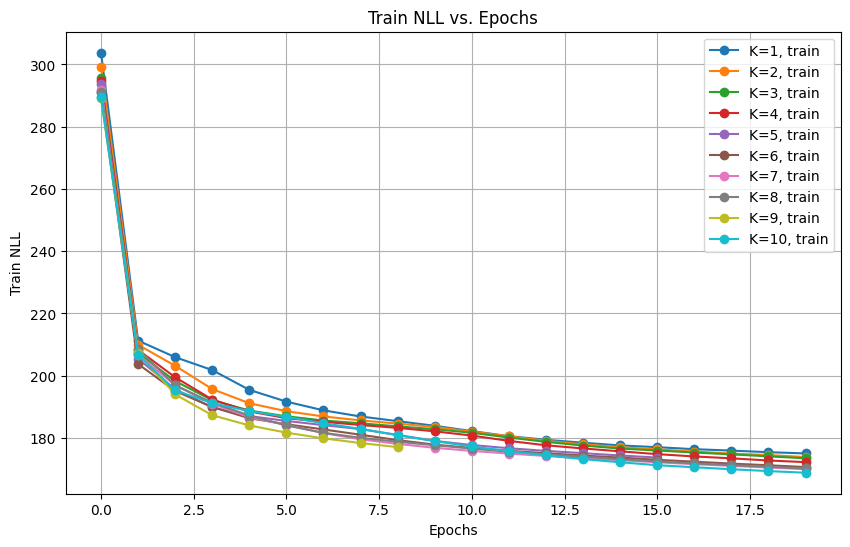

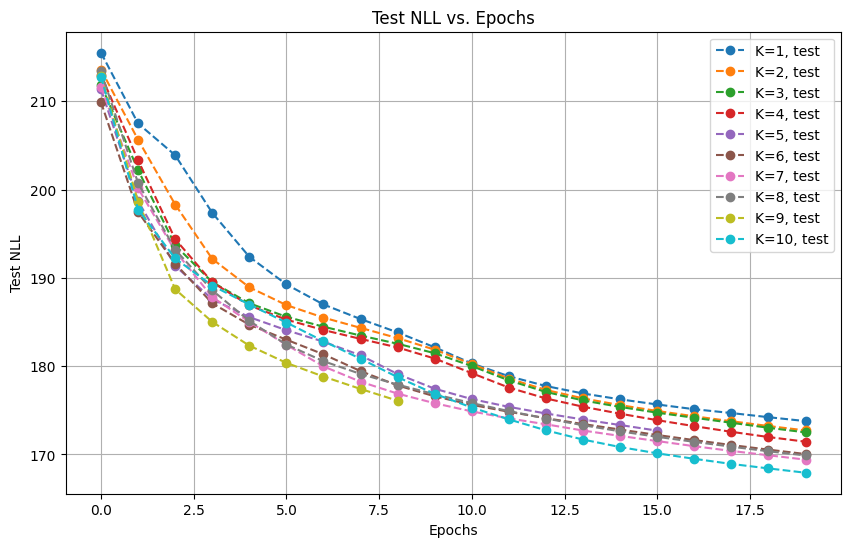

In [ ]:
plot_test_nll_vs_k()

Finally, it is valuable to know, how long did it take you to finish this practical?